In [ ]:
import pandas as pd

data_type = {
    'id' : 'int64',
    'NAME' : 'str',
    'host_id' : 'int64',
    'host_identity_verified' : 'str',
    'host name' : 'str',
    'neighbourhood group' : 'str',
    'neighbourhood' : 'str',
    'lat' : 'float64',
    'long' : 'float64',
    'country' : 'str',
    'country code' : 'str',
    'instant_bookable' : 'str',
    'cancellation_policy' : 'str',
    'room type' : 'str',
    'Construction year' : 'float64',
    'price' : 'str',
    'service fee' : 'str',
    'minimum nights' : 'float64',
    'number of reviews' : 'float64',
    'last review' : 'str',
    'reviews per month' : 'float64',
    'review rate number' : 'float64',
    'calculated host listings count' : 'float64',
    'availability 365' : 'float64',
    'house rules' : 'str',
    'license' : 'str'
}

df=pd.read_csv('data/Airbnb_Open_Data.csv', dtype=data_type)
df.head()

In [ ]:
airbnb = df.copy()

In [ ]:
airbnb.info()

In [ ]:
airbnb.isnull().sum()/len(airbnb)*100

In [ ]:
airbnb.isnull().sum()

In [ ]:
#  total duplicate value 
df.duplicated().sum()

In [ ]:
airbnb = airbnb.drop(columns=['host name', 'country','country code','license','last review'])

In [ ]:
# rename columns name for better understanding 
columns = {'id' : 'id',
           'NAME' : 'listing_name', 
           'host id':'host_id',
           'host_identity_verified':'host_verification',
           'neighbourhood group' :'neighbourhood_group', 
           'neighbourhood':'neighbourhood', 
           'lat':'latitude', 
           'long':'longitude',
           'instant_bookable':'instant_bookable',
           'cancellation_policy':'cancellation_policy',
           'room type':'room_type',
           'Construction year':'construction_year',
           'price':'price',
           'service fee':'service_fee', 
           'minimum nights':'min_nights',
           'number of reviews':'number_of_reviews',
           'reviews per month':'avg_reviews_per_month', 
           'review rate number':'star_rating',
           'availability 365':'yearly_availability'}

airbnb.rename(columns,axis=1,inplace=True)

In [ ]:
airbnb = airbnb.dropna(subset = ['listing_name', 'neighbourhood_group', 'neighbourhood', 'instant_bookable', 'cancellation_policy', 
                                 'construction_year', 'price', 'service_fee', 'yearly_availability'])

# Replacing host_verification NaN values with unconfirmed because there is no varifivcation confirmation of nan values .

airbnb['host_verification'] = airbnb['host_verification'].fillna('unconfirmed')


#  Replacig min_nights missing values with 1.0 . beacuse 1 is refer to lowest possible value with respact of columns . as well as 1 is most frequently comming numbers in column . 

airbnb['min_nights'] = airbnb['min_nights'].fillna(1.0)

# in number_of_reviews column ,i'll impute NaN value with 0 because value can't be replace with mean and median 
airbnb['number_of_reviews'] = airbnb['number_of_reviews'].fillna(0.0)

#in number_of_reviews column ,i'll impute NaN value with 0 because null value is availble on there ,where number_of_rewiews is equal to 0 
airbnb['star_rating'] = airbnb['star_rating'].fillna(0.0)

airbnb['price'] = airbnb['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).str.strip().astype(float)
airbnb['service_fee'] = airbnb['service_fee'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).str.strip().astype(float)

In [ ]:
airbnb = airbnb[~(airbnb['avg_reviews_per_month'].isnull() & airbnb['number_of_reviews'] > 0)]
airbnb['avg_reviews_per_month'] = airbnb[(airbnb['avg_reviews_per_month'].isnull() & airbnb['number_of_reviews']==0) ]['avg_reviews_per_month'].fillna(0)

airbnb = airbnb.dropna()

In [ ]:
airbnb.isnull().sum()

In [ ]:
airbnb.shape

In [ ]:
nyc_attractions = [
    {"name": "Statue of Liberty", "latitude": 40.6892, "longitude": -74.0445},
    {"name": "Central Park", "latitude": 40.7851, "longitude": -73.9683},
    {"name": "Times Square", "latitude": 40.7580, "longitude": -73.9855},
    {"name": "Empire State Building", "latitude": 40.7484, "longitude": -73.9857},
    {"name": "Brooklyn Bridge", "latitude": 40.7061, "longitude": -73.9969},
    {"name": "Metropolitan Museum of Art", "latitude": 40.7794, "longitude": -73.9632},
    {"name": "One World Trade Center", "latitude": 40.7127, "longitude": -74.0134},
    {"name": "Rockefeller Center", "latitude": 40.7587, "longitude": -73.9787},
    {"name": "Broadway", "latitude": 40.7590, "longitude": -73.9845},
    {"name": "Fifth Avenue", "latitude": 40.7750, "longitude": -73.9650}
]

import numpy as np
# Function to calculate the Haversine distance between two points on Earth
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Function to calculate the average distance from all 10 attractions
def calculate_avg_distance(row, attractions):
    distances = []
    for attraction in attractions:
        dist = haversine(row['latitude'], row['longitude'], attraction['latitude'], attraction['longitude'])
        distances.append(dist)
    return np.mean(distances)

# Apply the function to each row in the DataFrame
airbnb['avg_distance_to_attractions'] = airbnb.apply(lambda row: calculate_avg_distance(row, nyc_attractions), axis=1)
airbnb.head()

In [ ]:
from textblob import TextBlob

# Function to calculate sentiment polarity using TextBlob
def calculate_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply the sentiment calculation function to the 'description' column
airbnb['house_rules_sentiment'] = airbnb['house_rules'].apply(calculate_sentiment)
airbnb.head()

In [ ]:
airbnb.groupby('host_id').size().reset_index(name='count').sort_values(by='count', ascending=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of listings by neighborhood group
neighbourhood_counts = airbnb['neighbourhood_group'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=neighbourhood_counts.index, y=neighbourhood_counts.values, palette='viridis')
plt.title('Number of Listings by Neighborhood Group')
plt.xlabel('Neighborhood Group')
plt.ylabel('Count of Listings')
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='number_of_reviews', data=airbnb, hue='neighbourhood_group', palette='viridis')
plt.title('Price vs Number of Reviews by Neighborhood Group')
plt.xlabel('Price')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Create a map centered around NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(nyc_map)

# Add markers for each listing
for idx, row in airbnb.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], 
                  popup=f"Price: ${row['price']}, Reviews: {row['number_of_reviews']}",
                  icon=folium.Icon(color='blue', icon='home')).add_to(marker_cluster)

# Display the map
nyc_map.save('nyc_airbnb_map.html')
nyc_map

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=airbnb, hue='room_type')
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

In [34]:
airbnb

,id,listing_name,host_id,host_verification,neighbourhood_group,neighbourhood,latitude,longitude,instant_bookable,cancellation_policy,...,service_fee,min_nights,number_of_reviews,avg_reviews_per_month,star_rating,calculated host listings count,yearly_availability,house_rules,avg_distance_to_attractions,house_rules_sentiment
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,FALSE,strict,...,$193,10.0,9.0,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,11.514070,0.366667
1,1002102,Skylit Midtown Castle,52335172823,verified,Manhattan,Midtown,40.75362,-73.98377,FALSE,moderate,...,$28,30.0,45.0,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,3.175221,0.206818
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,unconfirmed,Manhattan,Harlem,40.80902,-73.94190,TRUE,flexible,...,$124,3.0,0.0,0.00,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",7.943890,-0.075000
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Manhattan,East Harlem,40.79851,-73.94399,FALSE,moderate,...,$41,10.0,9.0,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",6.871756,0.100000
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,verified,Manhattan,Murray Hill,40.74767,-73.97500,TRUE,flexible,...,$115,3.0,74.0,0.59,3.0,1.0,374.0,"No smoking, please, and no drugs.",3.491847,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102591,6090781,Columbus Ave Apt 1 block from Park,50908010324,verified,Manhattan,Upper West Side,40.77408,-73.98181,FALSE,strict,...,$228,5.0,17.0,0.35,5.0,1.0,134.0,#NAME?,3.868407,0.000000
102592,6091333,3BR/1 Ba in TriBeCa w/ outdoor deck,53266862889,unconfirmed,Manhattan,Tribeca,40.71845,-74.01183,FALSE,moderate,...,$157,1.0,0.0,0.00,2.0,1.0,177.0,Guests should treat my home as if it were thei...,4.964367,0.300000
102593,6091885,"Welcoming, Clean, Cheap on St Marks",33188605074,verified,Manhattan,East Village,40.72826,-73.98422,TRUE,strict,...,$220,1.0,8.0,0.16,4.0,2.0,152.0,* No smoking indoors. * No pets * No loud/la...,4.262376,0.245833
102594,6092437,Spare room in Williamsburg,12312296767,verified,Brooklyn,Williamsburg,40.70862,-73.94651,FALSE,flexible,...,$169,1.0,0.0,0.00,3.0,1.0,227.0,No Smoking No Parties or Events of any kind Pl...,6.725465,0.600000


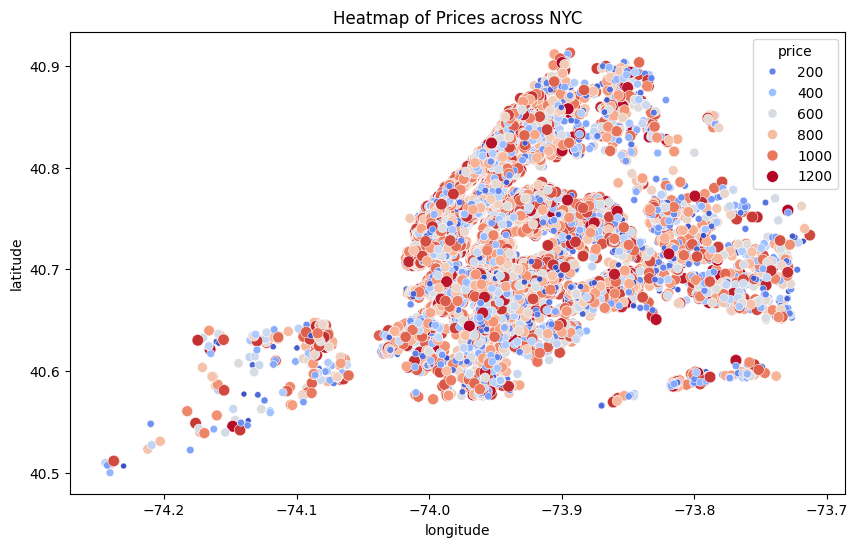

In [42]:
# Calculate the average price by neighborhood
avg_price_neighbourhood = airbnb.groupby('neighbourhood')['price'].mean().reset_index()

# Create a heatmap using lat/lon and average price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', size='price', hue='price', data=airbnb, palette='coolwarm')
plt.title('Heatmap of Prices across NYC')
plt.show()

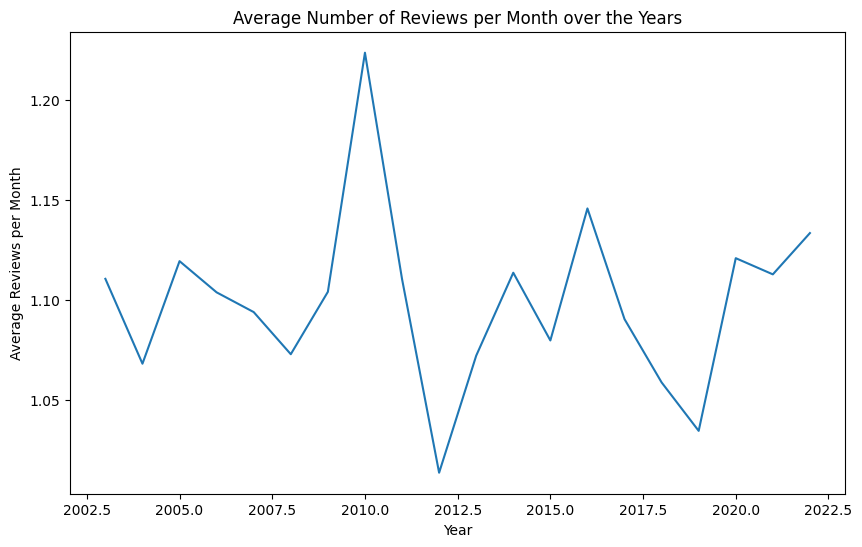

In [43]:
import numpy as np

# Create a new column for time series analysis if you have a date column
# Assuming `construction_year` is the listing year, otherwise you need actual dates of reviews
airbnb['year'] = np.floor(airbnb['construction_year'])

# Plot the trend of reviews over time
airbnb.groupby('year')['avg_reviews_per_month'].mean().plot(kind='line', figsize=(10, 6))
plt.title('Average Number of Reviews per Month over the Years')
plt.xlabel('Year')
plt.ylabel('Average Reviews per Month')
plt.show()
# Tutaj moze jakis z pogrupowaniem na miesiace zeby zobaczyc w ktorym miesiacu najwiecej ludzi

In [47]:
airbnb

,id,listing_name,host_id,host_verification,neighbourhood_group,neighbourhood,latitude,longitude,instant_bookable,cancellation_policy,...,min_nights,number_of_reviews,avg_reviews_per_month,star_rating,calculated host listings count,yearly_availability,house_rules,avg_distance_to_attractions,house_rules_sentiment,year
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,FALSE,strict,...,10.0,9.0,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,11.514070,0.366667,2020.0
1,1002102,Skylit Midtown Castle,52335172823,verified,Manhattan,Midtown,40.75362,-73.98377,FALSE,moderate,...,30.0,45.0,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,3.175221,0.206818,2007.0
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,unconfirmed,Manhattan,Harlem,40.80902,-73.94190,TRUE,flexible,...,3.0,0.0,0.00,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",7.943890,-0.075000,2005.0
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Manhattan,East Harlem,40.79851,-73.94399,FALSE,moderate,...,10.0,9.0,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",6.871756,0.100000,2009.0
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,verified,Manhattan,Murray Hill,40.74767,-73.97500,TRUE,flexible,...,3.0,74.0,0.59,3.0,1.0,374.0,"No smoking, please, and no drugs.",3.491847,0.000000,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102591,6090781,Columbus Ave Apt 1 block from Park,50908010324,verified,Manhattan,Upper West Side,40.77408,-73.98181,FALSE,strict,...,5.0,17.0,0.35,5.0,1.0,134.0,#NAME?,3.868407,0.000000,2005.0
102592,6091333,3BR/1 Ba in TriBeCa w/ outdoor deck,53266862889,unconfirmed,Manhattan,Tribeca,40.71845,-74.01183,FALSE,moderate,...,1.0,0.0,0.00,2.0,1.0,177.0,Guests should treat my home as if it were thei...,4.964367,0.300000,2016.0
102593,6091885,"Welcoming, Clean, Cheap on St Marks",33188605074,verified,Manhattan,East Village,40.72826,-73.98422,TRUE,strict,...,1.0,8.0,0.16,4.0,2.0,152.0,* No smoking indoors. * No pets * No loud/la...,4.262376,0.245833,2017.0
102594,6092437,Spare room in Williamsburg,12312296767,verified,Brooklyn,Williamsburg,40.70862,-73.94651,FALSE,flexible,...,1.0,0.0,0.00,3.0,1.0,227.0,No Smoking No Parties or Events of any kind Pl...,6.725465,0.600000,2003.0


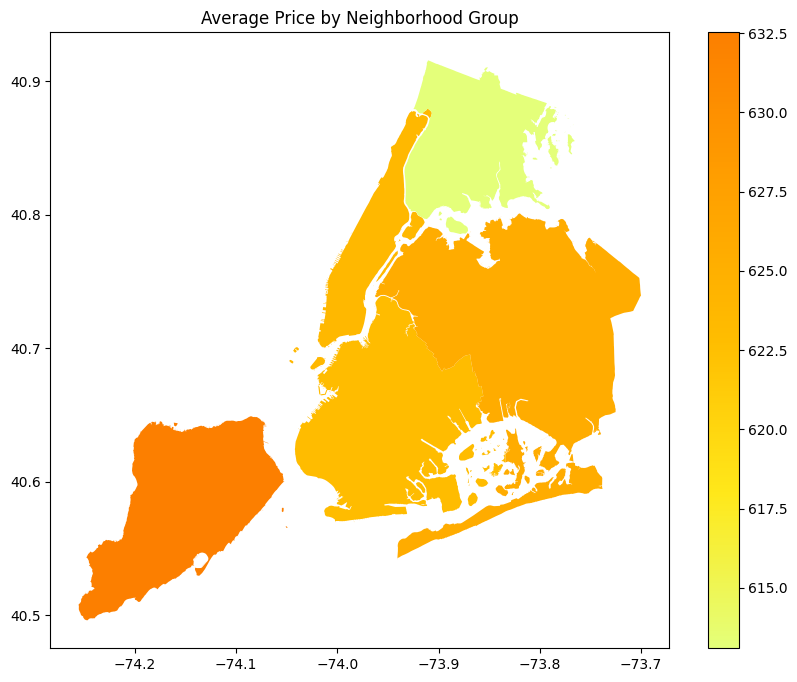

In [83]:
import geopandas as gpd

# Load the shapefile (ensure you have one for NYC neighborhoods)
nyc_shapefile = gpd.read_file('data/geo_export_4bd92b16-3dab-4b86-80ae-a5283a9caffa.shp')

# Calculate the average price by neighborhood group
neighbourhood_avg_price = airbnb.groupby('neighbourhood_group')['price'].mean().reset_index()

# Merge with the shapefile
nyc_geo = nyc_shapefile.merge(neighbourhood_avg_price, left_on='boro_name', right_on='neighbourhood_group')
# 
# # Plot a choropleth map
nyc_geo.plot(column='price', cmap='Wistia', legend=True, figsize=(10, 8))
plt.title('Average Price by Neighborhood Group')
plt.show()

In [68]:
nyc_shapefile.columns

Index(['boro_code', 'boro_name', 'shape_area', 'shape_leng', 'geometry'], dtype='object')

In [52]:
neighbourhood_avg_price

,neighbourhood_group,price
0,Bronx,613.095964
1,Brooklyn,622.922703
2,Manhattan,623.657599
3,Queens,625.564046
4,Staten Island,632.521327


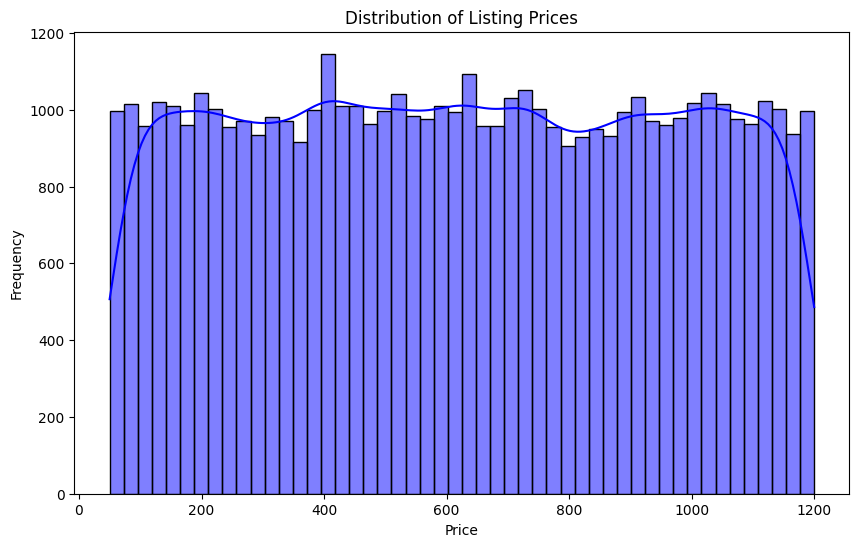

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(airbnb['price'], bins=50, kde=True, color='blue')
plt.title('Distribution of Listing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

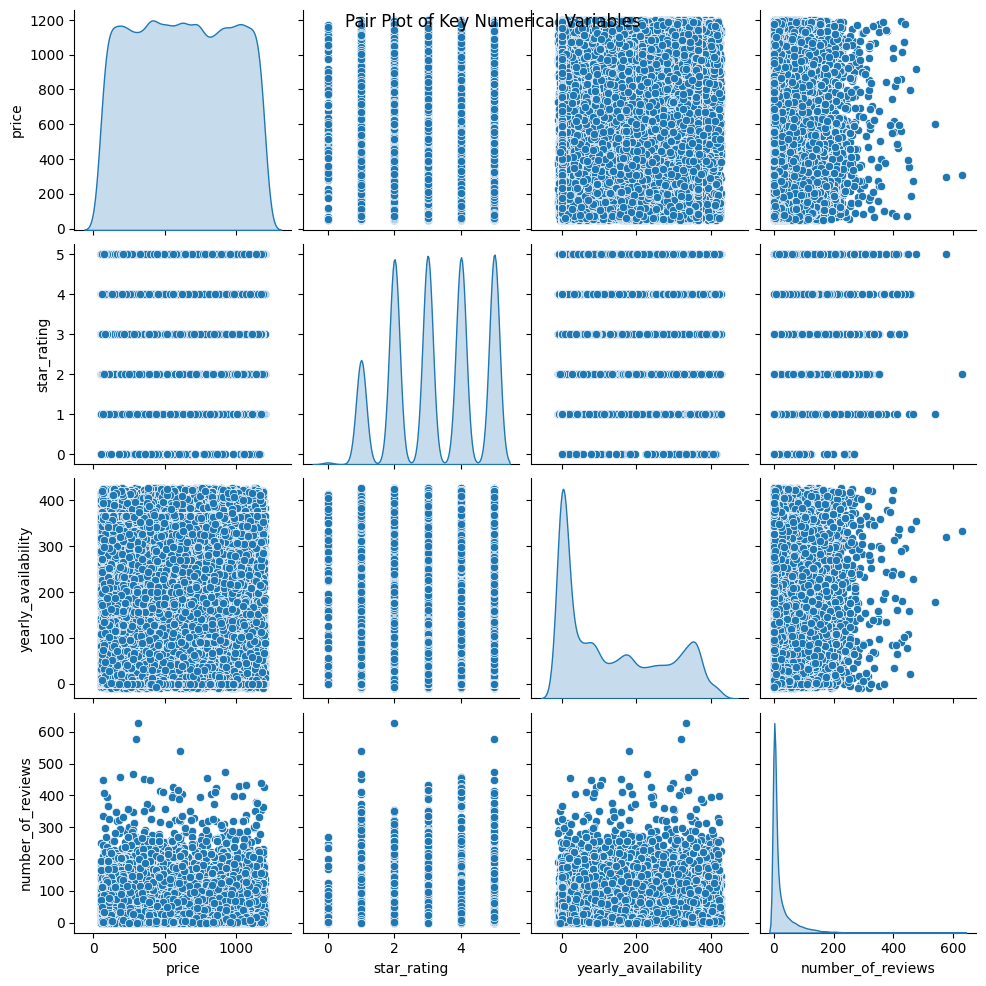

In [54]:
sns.pairplot(airbnb[['price', 'star_rating', 'yearly_availability', 'number_of_reviews']], kind='scatter', diag_kind='kde')
plt.suptitle('Pair Plot of Key Numerical Variables')
plt.show()

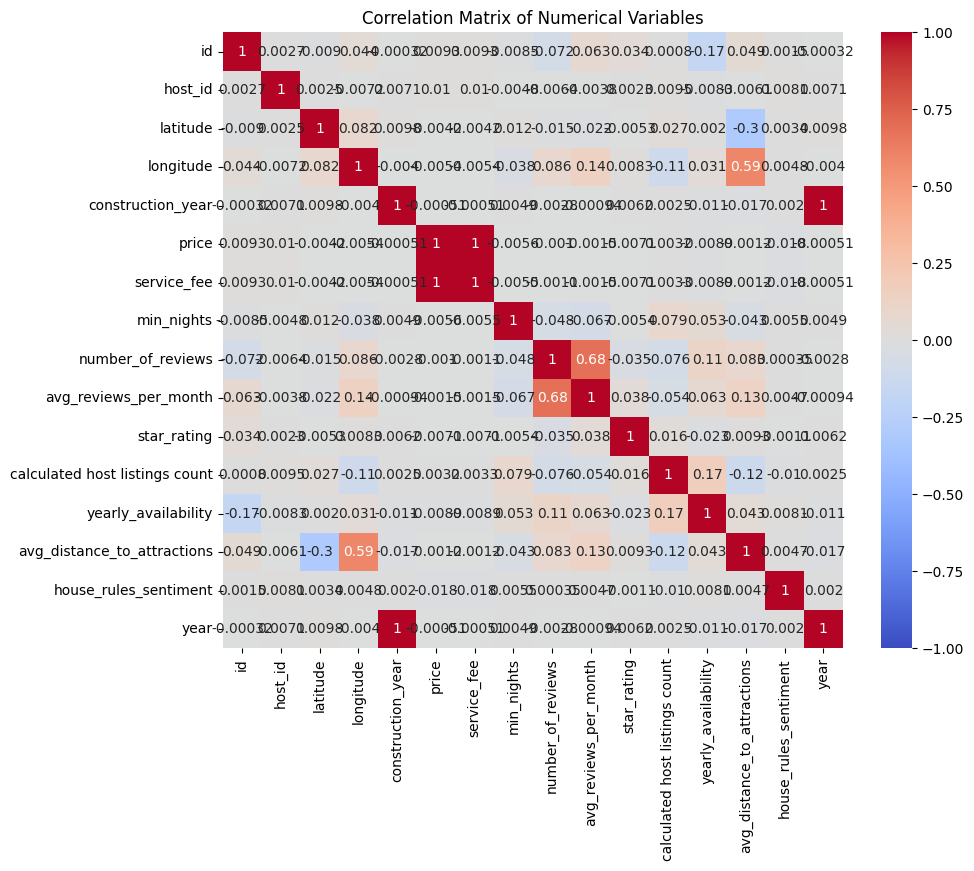

In [56]:
plt.figure(figsize=(10, 8))
sns.heatmap(airbnb.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()